# Homework 5: NLTK and Machine Learning Pipelines
### By: Samantha Cohen
### Uniqname: samcoh

In this final homework assignment, you'll be bringing together ideas from Natural Language Processing as well as
Machine Learning Pipelines.  This assignment uses materials adapted from [Benjamin Bengfort](https://bbengfort.github.io/tutorials/2016/05/19/text-classification-nltk-sckit-learn.html).

We are going back to work that you did in previous courses with object-oriented Python to create a proprocessor
to do NLP on some text in the context of machine learning pipelines.

First, we are going to review code that you should find reusable and helpful moving forward.  There's a lot of setup 
for this homework assignment.

In [1]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
import re #added this import 

from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
import pandas as pd 
import numpy as np
import json
import random


from bokeh.layouts import layout
from bokeh.layouts import widgetbox
from bokeh.embed import file_html
from bokeh.io import show
from bokeh.io import output_notebook
from bokeh.models import Text
from bokeh.models import Plot
from bokeh.models import Title
from bokeh.models import Slider
from bokeh.models import Circle
from bokeh.models import Range1d
from bokeh.models import CustomJS
from bokeh.models import HoverTool
from bokeh.models import LinearAxis
from bokeh.models import ColumnDataSource
from bokeh.models import SingleIntervalTicker
from bokeh.plotting import figure
#from bokeh.palettes import Spectral6
from bokeh.palettes import plasma
from bokeh.transform import factor_cmap


# from random import sample 
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
output_notebook()

Loading BokehJS ...

In [5]:
#better lemmer 
#better part of speech
class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    #init is a constructor, give it arguments. They are keyword arguments 
    def __init__(self, 
                 stopwords=None, 
                 punct=None,
                 lower=True, 
                 strip=True):
        self.lower = lower
        self.strip = strip
        self.punct = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        
        ##ADDED BELOW
        
        #get a set of english stop words and assign the value to the variable stopwords_to_use 
        stopwords_to_use = set(sw.words('english'))
        #create a list of string numbers to add to the set stopwords_to_use 
        add_nums = ["0","1","2", "3", "4", "5", "6", "7", "8", "9"]
        ## for each string-number in the list add_nums add each string-number to the stopwords_to_use set 
        for num in add_nums:
            stopwords_to_use.add(num)
        
        self.stopwords  = stopwords or set(stopwords_to_use) 
       
 
    #dont change 
    def fit(self, X, y=None):
        return self
    #dont change
    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]
    #dont change 
    def transform(self, X):  #transform call tokenizes 
        return [
            list(self.tokenize(doc)) for doc in X
        ]
    #lemmatizer does a better job between run the verb and ran the noun 
    def tokenize(self, document):
        ##ADDED BELOW: 
            ##get rid of the html tags using regex using this pattern 
        pattern = re.compile('<.*?>') 
     
        ## Break the document w/out html tag into sentences using sent_tokenize 
        for sent in sent_tokenize(document): 
            
            #removes the html tags from the sentence 
            sent = re.sub(pattern,'', sent)   #this replaces the html tags with an empty string 
            
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue 

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma #next time call this you pick up where you left off 

    def lemmatize(self, token, tag): #our part of speech tag form. N or P. Look at first chacracter 
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

This just takes text and returns it unmodified.  We need it in the next section

In [6]:
def identity_tokenizer(text): #create null function and takes some text and returns that text 
    #does not change anything just returns the identity - the text itself 
    return text

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report as clsr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as tts
import time
import pickle


def build_and_evaluate(X, y,
    classifier=SGDClassifier, outpath=None, verbose=True):

    def build(classifier, X, y=None):
        """
        Inner build function that builds a single model.
        """
        #dont have instance of classifier than generate instance of classifier 
        if isinstance(classifier, type):
            classifier = classifier()
        #this is a pipeline. 
        model = Pipeline([
            ('preprocessor', NLTKPreprocessor()),#calling class we created 
            ('vectorizer', TfidfVectorizer(  
                tokenizer=identity_tokenizer, # note that this will fail unless you use the identity_tokenizer
                preprocessor=None, lowercase=False
            )), 
            ('classifier', classifier), #SET TO WHATEVER YOU PASS IN 
        ])

        model.fit(X, y) #fit model with train data passed in 
        return model

    # Label encode the targets
    labels = LabelEncoder()
    y = labels.fit_transform(y) #fit_transform on label encoder and assign it back to y 

    # Begin evaluation
    if verbose: print("Building for evaluation")
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    
    import time
    start_time = time.time()

    model = build(classifier, X_train, y_train)

    if verbose:
        print("Evaluation model fit in {:0.3f} seconds".format(time.time() - start_time))
        print("Classification Report:\n")

    y_pred = model.predict(X_test)
    print(clsr(y_test, y_pred, target_names=labels.classes_))

    if verbose:
        print("Building complete model and saving ...")
    start_time = time.time()
    model = build(classifier, X, y)
    model.labels_ = labels
    
    if verbose:
        print("Complete model fit in {:0.3f} seconds".format(time.time() - start_time))

    if outpath:
        with open(outpath, 'wb') as f:
            pickle.dump(model, f) #pickel save object and load it back in again 

        print("Model written out to {}".format(outpath))
        
    #added line below to check to see the accuracy score of every model 
    score = accuracy_score(y_test, y_pred)
    return model, score 

Now that we've got everything set up for our pipelines, we can load some data.  Here we're going to use the Movie Reviews
corpus from the NLTK package.

In [8]:
from nltk.corpus import movie_reviews as reviews

X = [reviews.raw(fileid) for fileid in reviews.fileids()]
y = [reviews.categories(fileid)[0] for fileid in reviews.fileids()]
print("There are {} reviews".format(len(y)))


There are 2000 reviews


In [9]:
#reviews.raw('neg/cv000_29416.txt')

In [10]:
#reviews.raw()

In [11]:
# we can take a closer look at the structure of 'reviews'

In [12]:
PATH = "movie_reviews_model.pickle"

In [13]:
# PATH = "movie_reviews_model.pickle"
model = build_and_evaluate(X,y, classifier=SGDClassifier, outpath=PATH)

Building for evaluation
Evaluation model fit in 53.401 seconds
Classification Report:

              precision    recall  f1-score   support

         neg       0.78      0.80      0.79       200
         pos       0.79      0.78      0.79       200

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400

Building complete model and saving ...
Complete model fit in 63.972 seconds
Model written out to movie_reviews_model.pickle


In [14]:
#how much of the positives were negative 
#interested in accuracy 

As you can see, building a model takes a considerable amount of time (and resources), so we're going to use the
"pickled" version of the model so we don't have to recreate it.

In [15]:
#load saved model and predict 
with open(PATH, 'rb') as f:
    model = pickle.load(f)

yhat = model.predict([
    "This is the worst movie I have ever seen!",
    "The movie was great action packed and full of adventure!",
    "Wow!",
    "This was the best and the worst at the same time!"
])


print(yhat) #0 1 0 0 
print(model.labels_.inverse_transform(yhat))
#map on to labels 

[0 1 0 0]
['neg' 'pos' 'neg' 'neg']


Finally, we can take a look to see which words are most highly associated with each sentiment:

In [16]:
from operator import itemgetter
def show_most_informative_features(model, text=None, n=20):
    # Extract the vectorizer and the classifier from the pipeline
    vectorizer = model.named_steps['vectorizer']
    classifier = model.named_steps['classifier']

    # Check to make sure that we can perform this computation
    if not hasattr(classifier, 'coef_'):
        raise TypeError(
            "Cannot compute most informative features on {}.".format(
                classifier.__class__.__name__
            )
        )

    if text is not None:
        # Compute the coefficients for the text
        tvec = model.transform([text]).toarray()
    else:
        # Otherwise simply use the coefficients
        tvec = classifier.coef_

    # Zip the feature names with the coefs and sort
    coefs = sorted(
        zip(tvec[0], vectorizer.get_feature_names()),
        key=itemgetter(0), reverse=True
    )

    # Get the top n and bottom n coef, name pairs
    topn  = zip(coefs[:n], coefs[:-(n+1):-1])

    # Create the output string to return
    output = []

    # If text, add the predicted value to the output.
    if text is not None:
        output.append("\"{}\"".format(text))
        output.append(
            "Classified as: {}".format(model.predict([text]))
        )
        output.append("")

    # Create two columns with most negative and most positive features.
    for (cp, fnp), (cn, fnn) in topn:
        output.append(
            "{:0.4f}{: >15}    {:0.4f}{: >15}".format(
                cp, fnp, cn, fnn
            )
        )

    return "\n".join(output)

In [17]:
print(show_most_informative_features(model))

2.6828            fun    -4.7290            bad
2.5205          great    -2.6989  unfortunately
2.0901    performance    -2.5090          waste
2.0830            see    -2.4804        nothing
1.9792         matrix    -2.4689           plot
1.8342          quite    -2.4475        suppose
1.7137      memorable    -2.4316        attempt
1.6940           trek    -1.9850           poor
1.6509       bulworth    -1.9788          awful
1.6446      different    -1.9238         boring
1.5903       terrific    -1.9236           look
1.5618        portray    -1.8875         stupid
1.5411      hilarious    -1.8327          guess
1.5374           also    -1.7941     ridiculous
1.5323            job    -1.7805           even
1.5192        overall    -1.7333         script
1.5005      excellent    -1.6732          could
1.4982     especially    -1.6669      carpenter
1.4896           true    -1.6149         anyway
1.4777      enjoyable    -1.5915           lame


## Your challenge:
Build a sentiment classifier for the IMDB Dataset, which is available in the data/ directory.  Please note that
the IMDB Dataset consists of 50000 rows, so it's probably best to do most of your work on a sample of the
original dataset.  In the code below we use a sample size of 1000.  That's probably fine to start with but your final submission should be based on a sample of at least 5000.

You should attempt to improve the default classifier shown above by trying to get a higher accuracy score.  For example, you might want to try one of the other classifiers from the list shown in class 22.  Another way to improve your pipeline is to spend more time
building a better text preprocessor (e.g. you can see some reviews contain HTML, which you might decide to strip out).  Another thing you might want to do is to look more closely at the stopword list.

Please note that if you resample the dataset you will get slightly different accuracy values.  The values should not fluctuate wildly, so don't get too concerned about their absolute value.  What we're looking for is an improvement from the baseline and evidence that you tried a variety of approaches to improving the classifier.  We're also looking for evidence that you can manipulate text data into a machine learning pipeline and correctly interpret the results.

You should include code and interpretation of your results in this notebook.   If you tried many different approaches and ultimately chose one over the others, please include that in your write-up.  You do not need to include code for analyses that you discarded.

You should be able to plug the new data into the old pipeline code to get started (another handy thing about pipelines) and then start experimenting with improving the code!

## 1. Load in IMBD Data and take a sample of 5000. 

In [18]:
import pandas as pd

In [19]:
m = pd.read_csv("data/imdb-dataset-of-50k-movie-reviews.zip") #handles a zip file 
# Let's do most of our work on a smaller sample of the 50000 rows
m = m.sample(5000)

In [20]:
m.head()

,review,sentiment
11936,I liked this film very much. The story jumps b...,positive
30205,Dear me. Where do I start? The dad isn't anywh...,negative
48567,I saw The D's new film tonight at a special ad...,positive
36385,The only reason I bought the DVD was to satisf...,negative
31602,"I have never been a great fan of Oliver Stone,...",positive


## 2. In the DataFrame m, assign columns review and sentiment to variables X and y. X is all the variables, in this case reviews, that will be used to predict the type of sentiment. The variable y is the categorical variable sentiment. 
- X is the features, in this case reviews, that will be used to try and figure out the classification. 
- The values of variable y is what we are trying to predict. In this case, we are trying to predict a review's sentiment based on words used in review. 

In [21]:
# INSERT YOUR CODE AND INTERPRETATION IN MULTIPLE CELLS BELOW THIS ONE
X = m["review"]
y = m["sentiment"]

## 3. Explanation of Changes

#### Explanation of Improvement: 

**1) Improve preprocessor**
1. *Added string-numbers to the list of Stopwords*:  I improved the preprocessor by adding string numbers to the list of stopwords (0-9 were added). I did this because before numbers such as 7 and 8 were important features that were used to classify a review as having positive sentiment. After looking into this, I realized that numbers were not predictive of positive sentiment because you do not know the scale that reviewer is rating the movie out of. A reviewer could rate a movie as 7/10 or 7/100. Therefore, numbers are not a good feature to use when predicting sentiment so it is best remove them as a word feature. 

        class NLTKPreprocessor(BaseEstimator, TransformerMixin):
            #init is a constructor, give it arguments. They are keyword arguments 
            def __init__(self, 
                         stopwords=None, 
                         punct=None,
                         lower=True, 
                         strip=True):
                self.lower = lower
                self.strip = strip
                self.punct = punct or set(string.punctuation)
                self.lemmatizer = WordNetLemmatizer()
                
                ##ADDED BELOW
                
                #get a set of english stop words and assign the value to the variable stopwords_to_use 
                stopwords_to_use = set(sw.words('english'))
                
                #create a list of string numbers to add to the set stopwords_to_use  
                add_nums = ["0","1","2", "3", "4", "5", "6", "7", "8", "9"]
                
                ## for each string number in the list add_nums add the number to the stopwords_to_use set 
                for num in add_nums:
                    stopwords_to_use.add(num)

                self.stopwords  = stopwords or set(stopwords_to_use) 
           ...


2. *Removed HTML Tags*: I improved the preprocessor by taking out HTML tags using regex. I made these changes within the class NLTKPreprocessor under the method tokenize. Below I copied and pasted the code I changed in the method above, and described the changes. 

        ...

         def tokenize(self, document):
            ##ADDED BELOW: 
                ##get rid of the html tags using regex using this pattern 
            pattern = re.compile('<.*?>') 

            ## Split the document into sentences using sent_tokenize 
            for sent in sent_tokenize(document): 

                #removes the html tags from the sentence 
                sent = re.sub(pattern,'', sent)   #this replaces the html tags with an empty string 
                ...
        ...
    I used regex to take out the html tags within each sentence. I replaced the html tag with an empty string. I did this by using the methods compile and sub. The compile method allowed me to compile a regular expression pattern into a regular expression object (https://docs.python.org/2/library/re.html). As well, the method sub allowed me to return a string that replaces html tags with an empty string. The method sub does this by replacing the leftmost non-overlapping occurrences of the pattern in string by using a replacement string specified. The method sub, uses the pattern created in compile to find the html tags. 

    Below I exemplify how the code block I added works. In the example below, I took a random review from the sample dataset. Afterwards, I used string_tokenized on the review, to split the review into sentences, and looped through each sentence in the list. I used the re.compile and re.sub to make changes to the string if an html tag is present. I printed the string before it is altered, and the string after it is altered. As you can see, if there is no tags the string is returned unchanged, but when tags are present they are removed and replaced with an empty string. 



In [75]:
string_to_change =m["review"].values[2]

In [76]:
string_tokenized_example = sent_tokenize(string_to_change)
n = 1 
for x in string_tokenized_example: 
    print("\nBefore: ")
    print('\t' + x)
    print("\nAfter: ")
    pattern = re.compile('<.*?>')
    sent = re.sub(pattern, '', x)
    print('\t'+ sent)
    


Before: 
	I saw The D's new film tonight at a special advance screening, and I was so blown away by its sheer greatness that I felt I had to come onto IMDb and get the word out.

After: 
	I saw The D's new film tonight at a special advance screening, and I was so blown away by its sheer greatness that I felt I had to come onto IMDb and get the word out.

Before: 
	Admittedly, I was already a huge fan of the D's work - I loved the HBO series and listen to their music weekly (there's nothing better to sing along to), but this appreciation actually made me more apprehensive going into to tonight's screening (for we've all been disappointed one time or another by something we love when it attempted to make the jump to the big screen).

After: 
	Admittedly, I was already a huge fan of the D's work - I loved the HBO series and listen to their music weekly (there's nothing better to sing along to), but this appreciation actually made me more apprehensive going into to tonight's screening (fo



**2) Altered build_and_evaluate**

1. I also altered the function build_and_evaluate. I altered the function by adding a line the calculates the accuracy score of the model. Before, this function returned one object, the model, but now it returns a tuple: the model and the model's accuracy score. Therefore, the function now returns the model object and an integer representing the accuracy score. 

        def build_and_evaluate(X, y,
            classifier=SGDClassifier, outpath=None, verbose=True):

             ...
         
            #added line below to check to see the accuracy score of every model 
            score = accuracy_score(y_test, y_pred)
            return model, score 

    I made this change so I was able to test multiple classifiers and compare the accuracy score of each model to one another; thereby, allowing me to compare and choose the model with the best accuracy score. The necessity of this change is further shown in part 4. 
    
    
**3) Added import statments to the top of the notebook**

1. Another change i made to the notebook is importing addition modules that I needed. This is shown at the top of the notebook

## 4. Evidence of multiple classifiers attempted
- Tried a total of 8  classifiers:  
    1. "KNeighborsClassifier"
    2. "SVC"
    3. "NuSVC"
    4. "DecisionTreeClassifier"
    5. "RandomForestClassifier"
    6. "AdaBoostClassifier"
    7. "GradientBoostingClassifier"
    8. "SGDClassifier"

### a) Create a Path that will pickle the model with the highest accuracy score 

In [24]:
PATH = "My_IMDB_movie_reviews_model.pickle"

### b) Create a List of classifiers to try, and a list of classifier_names. Afterwards, use a for loop to try all the classifiers within the list classifiers. 
- When iterating through the list of classifiers, create a dictionary called classifier_accuracy_score that has the classifier name as the key and the accuracy score of the model as the value. 
- Overwrite the pickle file with the new model if the model has the highest accuracy score. Therefore, in the end the pickle file will store the model object with the highest accuracy score.  

In [25]:

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(nu=0.1,probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(), 
    SGDClassifier()
    ]
classifier_names = [
    "KNeighborsClassifier",
    "SVC",
    "NuSVC",
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "AdaBoostClassifier",
    "GradientBoostingClassifier", 
    "SGDClassifier"
    ]

In [26]:
n = 0 
classifier_accuracy_score = {}
for classifier in classifiers:
    name = classifier_names[n]
    n += 1 
    print("Classification Type: {}".format(classifier))
    model, score = build_and_evaluate(X=X,y=y, classifier=classifier)#, outpath=PATH)
    #did not set outpath=PATH because do not want the model to write to the file everytime. Only if model has the highest accuracy score 
    if n == 1: 
        previous_score = score
        with open(PATH, 'wb') as f:
            pickle.dump(model, f) #pickel save object and load it back in again           
    elif score > previous_score:  #will only overwrite pickel file with new model if the accuracy score is higher than the previously highest score 
        previous_score = score 
        with open(PATH, 'wb') as f:
            pickle.dump(model, f) #pickel save object and load it back in again 
    print("Accuracy Score of Model: {}%".format(score *100))
    print("====================================================================")
    classifier_accuracy_score[name] = score
print("done.")            
#     pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', classifier)])
#     pipe.fit(X_train, y_train)   
#     print(classifier)
#     print("model score: %.3f" % pipe.score(X_test, y_test))

Classification Type: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Building for evaluation
Evaluation model fit in 44.787 seconds
Classification Report:

              precision    recall  f1-score   support

    negative       0.71      0.72      0.71       478
    positive       0.74      0.73      0.74       522

    accuracy                           0.73      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.73      0.72      0.73      1000

Building complete model and saving ...
Complete model fit in 55.033 seconds
Accuracy Score of Model: 72.5%
Classification Type: SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Buildin

/Users/Sammie/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Evaluation model fit in 97.945 seconds
Classification Report:



/Users/Sammie/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       481
    positive       0.52      1.00      0.68       519

    accuracy                           0.52      1000
   macro avg       0.26      0.50      0.34      1000
weighted avg       0.27      0.52      0.35      1000

Building complete model and saving ...


/Users/Sammie/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Complete model fit in 144.702 seconds
Accuracy Score of Model: 51.9%
Classification Type: NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.1, probability=True, random_state=None,
      shrinking=True, tol=0.001, verbose=False)
Building for evaluation


/Users/Sammie/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Evaluation model fit in 47.516 seconds
Classification Report:

              precision    recall  f1-score   support

    negative       0.59      0.98      0.73       509
    positive       0.93      0.29      0.44       491

    accuracy                           0.64      1000
   macro avg       0.76      0.63      0.59      1000
weighted avg       0.76      0.64      0.59      1000

Building complete model and saving ...


/Users/Sammie/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Complete model fit in 60.883 seconds
Accuracy Score of Model: 63.9%
Classification Type: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Building for evaluation
Evaluation model fit in 42.785 seconds
Classification Report:

              precision    recall  f1-score   support

    negative       0.70      0.69      0.69       489
    positive       0.71      0.72      0.71       511

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000

Building complete model and saving ...
Complete model fit in 56.187 seconds
Accuracy Score o

/Users/Sammie/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Evaluation model fit in 42.570 seconds
Classification Report:

              precision    recall  f1-score   support

    negative       0.68      0.82      0.74       485
    positive       0.79      0.63      0.70       515

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000

Building complete model and saving ...
Complete model fit in 55.264 seconds
Accuracy Score of Model: 72.1%
Classification Type: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Building for evaluation
Evaluation model fit in 45.317 seconds
Classification Report:

              precision    recall  f1-score   support

    negative       0.81      0.73      0.77       499
    positive       0.75      0.83      0.79       501

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.7

### c) Use the Dictionary Created above, called classifier_accuracy_score, and create a pandas DataFrame that represents all classifers tested and their accuracy score. There will be two columns: classifier_name and accuracy_score. 

In [27]:
df = pd.DataFrame(data = {
    "classifer_name": list(classifier_accuracy_score.keys()), 
    "accuracy_score": list(classifier_accuracy_score.values()), 
    })

In [28]:
#change accuracy_score column into a percentage by multiplying by 100 
df["accuracy_score"] = df["accuracy_score"] *100 

### d) Plot the DataFrame created above, called df, to figure out the best classifier based on accuracy. 

In [29]:
#sort df from lowest to highest 
df = df.sort_values("accuracy_score", ascending= True)

In [30]:
select_tools = ['box_select', 'lasso_select', 'poly_select', 'tap', 'reset']
p = figure(y_range =list(df["classifer_name"]),
           x_range = (0,100), 
           #x_range = (list(top_50_ingredients["Ingredients"])),
           plot_height=600,
           plot_width=800,
           x_axis_label='Accuracy Score (%)',
           y_axis_label='Classifier Type',
           title='''Comparing the Accuracy Scores of Different Classifiers Tested''',
          )
#Classifiers Tried and their Associated Accuracy Scores
p.hbar(y='classifer_name', right= "accuracy_score", 
       left = 0, 
       height = 0.4, 
       color = "orange",  
       hover_color="black",
       source = df)


tooltips = [
            ('Classifier','@classifer_name'),
            ('% Accuracy Score','@accuracy_score')
           ]

# Add the HoverTool to the figure
p.add_tools(HoverTool(tooltips=tooltips))

show(p)

#### Explanation of Findings: 
The SGDClassifier has the highest accuracy score. After making changes to the preprocessing section, the accuracy score is now 83.80% percent. The GradientBoostingClassifier is a comparatively good classifer, but is less accurate than the SGDClassifer. The  GradientBoostingClassifier has an accuracy score of 78%. As well, from the visualization you can see that SVC Classifier has the lowest accuracy score of 51.90%. 

## 4. Tune the hyperparameters of SGDClassifier to increase the accuracy of the model. 

### a) Tune the parameters of the model using GridSearchCV

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [32]:
with open(PATH, 'rb') as f:
    rf_model = pickle.load(f)

In [33]:
rf_model.get_params().keys()
#review parameters you can use 

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'vectorizer', 'classifier', 'preprocessor__lower', 'preprocessor__punct', 'preprocessor__stopwords', 'preprocessor__strip', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__norm', 'vectorizer__preprocessor', 'vectorizer__smooth_idf', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__sublinear_tf', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__use_idf', 'vectorizer__vocabulary', 'classifier__alpha', 'classifier__average', 'classifier__class_weight', 'classifier__early_stopping', 'classifier__epsilon', 'classifier__eta0', 'classifier__fit_intercept', 'classifier__l1_ratio', 'classifier__learning_rate', 'classifier__loss', 'classifier__max_iter', 'classifier__n_iter_no_c

#### Explanation: 
After reviewing the parameters of the model, and doing research online, I am going to improve the model by tuning the hyperparameter called classifier__max_iter. 

In [34]:
param_grid = {
                 'classifier__max_iter': [5, 100, 500, 1000]
             }

In [35]:
grid_clf = GridSearchCV(rf_model, param_grid, cv=5)
#grid_clf.fit(X,y)

In [36]:
grid_clf.fit(X,y)

/Users/Sammie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Sammie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Sammie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/Sammie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/S

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        NLTKPreprocessor(lower=True,
                                                         punct={'!', '"', '#',
                                                                '$', '%', '&',
                                                                "'", '(', ')',
                                                                '*', '+', ',',
                                                                '-', '.', '/',
                                                                ':', ';', '<',
                                                                '=', '>', '?',
                                                                '@', '[', '\\',
                                                                ']', '^', '_',
                                                                '`

In [37]:
grid_clf.best_params_

{'classifier__max_iter': 500}

#### Explanation: 
The best parameters for the model is when max_iter equals 500. 

### b) Calculate accuracy score for this better model. 

In [38]:
means = grid_clf.cv_results_['mean_test_score']

In [39]:
stds = grid_clf.cv_results_['std_test_score']


In [40]:
for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
#     print("Accuracy: %0.2f (+/- %0.2f) for %r" %
#           (mean,std * 2, params))
    print("Accuracy: %0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
        
        

Accuracy: 0.850 (+/-0.014) for {'classifier__max_iter': 5}
Accuracy: 0.849 (+/-0.015) for {'classifier__max_iter': 100}
Accuracy: 0.850 (+/-0.018) for {'classifier__max_iter': 500}
Accuracy: 0.848 (+/-0.016) for {'classifier__max_iter': 1000}


### Explanation: 
Before tuning the hyperparameters, the accuracy score of the SGDClassifier was 83.80%. After tuning the hyperparameters, I found that the best parameter, from the different values tested (5, 100, 500, and 1000), is when when max_iter = 500. When max_iter equals 500, the accuracy of the model increased. The accuracy of the new model is now 0.850, or 85.00%. Although, it is important to note that when max_iter equals 5 it appears to have the same accuracy score of 85.00%. Although, when using the attribute best_params_ the result was max_iter equals 500. Therefore, the accuracy score when max_iter equals 500 must be slightly higher than the accuracy score when max_iter equals 5. 

### c) Now, assign the best estimator to the variable best_model. After,  overwrite the pickle file and dump best_model to the pickle file. 

In [41]:
#retrieve the best model from grid_clf using the attribute best_estimator_ and 
#assign it to the variable best_model

best_model = grid_clf.best_estimator_

In [42]:
#load old model - this is done just in case i need to reference the old model later. I assigned the old model
#to the variable model_before

with open(PATH, 'rb') as f:
    model_before = pickle.load(f)

In [43]:
#dump the best_model into the pickle file 

with open(PATH, 'wb') as f:
    pickle.dump(best_model, f) 

## 5. Now, get predicted labels for the sample dataset used, and compare predicted labels with Acutal labels. 

### a) get the predicted labels for the best model using m["review"]

In [44]:
#open the pickle file and load in the model (now it will be the best model with the tuned hyperparameters found above)
with open(PATH, 'rb') as f:
    model = pickle.load(f)


In [45]:
predicted_labels = model.predict(m["review"])


In [46]:
predicted_labels

array(['positive', 'negative', 'positive', ..., 'negative', 'positive',
       'positive'], dtype='<U8')

### b) Create a copy of the DataFrame m, and assign it to the variable sentiment_for_IMBD. The DataFrame sentiment_for_IMBD will be altered and used throughout the code. 
- I am going to add columns to this DataFrame. 

In [47]:
#create a copy of the DataFrame and assign it the variable 
sentiment_for_IMBD = m.copy()

In [48]:
sentiment_for_IMBD.head(5)

,review,sentiment
11936,I liked this film very much. The story jumps b...,positive
30205,Dear me. Where do I start? The dad isn't anywh...,negative
48567,I saw The D's new film tonight at a special ad...,positive
36385,The only reason I bought the DVD was to satisf...,negative
31602,"I have never been a great fan of Oliver Stone,...",positive


### c) Create a column in sentiment_for_IMBD called predicted. This column will have the predicted sentiment  labels that are assigned to the variable predicted_labels, which was found above. 

In [49]:
sentiment_for_IMBD["predicted"] = predicted_labels

In [50]:
#replace the sentiment labels in the predicted column with negative or positive 
sentiment_for_IMBD["predicted"].replace(to_replace = {0:"negative", 
                                                      1: "positive",
                                                      "pos": "positive", 
                                                      "neg": "negative"
                                                     }, inplace = True)

### d) create a grouped bar graph using bokeh that compares the number of correctly predicted sentiment labels with incorrectly predicted sentiment labels.

In [51]:
#filter sentiment_for_IMBD for correctly predicted labels  
correct_sent = sentiment_for_IMBD[
                                sentiment_for_IMBD['sentiment'] == sentiment_for_IMBD['predicted']
                                 ]


In [52]:
correct_sent.head()

,review,sentiment,predicted
11936,I liked this film very much. The story jumps b...,positive,positive
30205,Dear me. Where do I start? The dad isn't anywh...,negative,negative
48567,I saw The D's new film tonight at a special ad...,positive,positive
36385,The only reason I bought the DVD was to satisf...,negative,negative
31602,"I have never been a great fan of Oliver Stone,...",positive,positive


In [53]:
#filter sentiment_for_IMBD for incorrectly predicted labels 
incorrect_sent = sentiment_for_IMBD[sentiment_for_IMBD['sentiment'] != sentiment_for_IMBD['predicted']]


In [54]:
incorrect_sent.head()

,review,sentiment,predicted
35972,"let me first just say that in the past, i have...",negative,positive
15064,This movie was pure genius. John Waters is bri...,negative,positive
1216,Mickey Rourke hunts Diane Lane in Elmore Leona...,negative,positive
15153,Comedy Central has had success with original p...,negative,positive
23354,I was really surprised with this movie. Going ...,positive,negative


In [55]:
#count the number of correctly predicted labels 
correct_sentiment= correct_sent.groupby("sentiment")["predicted"] \
    .count() \
    .reset_index(name ="Number_Correct")

In [56]:
correct_sentiment

,sentiment,Number_Correct
0,negative,2445
1,positive,2533


In [57]:
#count the number of incorrectly predicted labels 
incorrect_sentiment=incorrect_sent.groupby("sentiment")["predicted"] \
    .count() \
    .reset_index(name ="Number_Incorrect")

In [58]:
incorrect_sentiment

,sentiment,Number_Incorrect
0,negative,10
1,positive,12


In [59]:
#merge the two dataframes correct_sentiment and incorrect_sentiment to get combined counts
correct_and_incorrect= incorrect_sentiment.merge(correct_sentiment, on = "sentiment")

In [60]:
correct_and_incorrect

,sentiment,Number_Incorrect,Number_Correct
0,negative,10,2445
1,positive,12,2533


In [61]:
#Below creates a grouped bar graph

In [62]:
from bokeh.models import FactorRange
sentiments = list(correct_and_incorrect['sentiment'])
right_or_wrong = ['incorrect', 'correct']

data = {'sentiment': sentiments, 
        'incorrect': list(correct_and_incorrect['Number_Incorrect']),
        'correct': list(correct_and_incorrect['Number_Correct'])}

# data

x = [(c, rw) for c in sentiments for rw in right_or_wrong]
counts = sum(zip(data['incorrect'], data['correct']), ())



source = ColumnDataSource(data=dict(x=x, counts=counts))

plot = figure(x_range=FactorRange(*x), plot_height=500, plot_width=600, title="Comparing Accuracy of Predicted Labels by Sentiment")

plot.vbar(x='x', top='counts', width=1, source=source, line_color='white',
          fill_color=factor_cmap('x', palette=['tomato', '#3CB371'], factors=right_or_wrong, start=1, end=2))
    
plot.y_range.start = 0
plot.x_range.range_padding = 0.01
# plot.xaxis.major_label_orientation = 1.55
# plot.xaxis.group_label_orientation = 1
plot.xgrid.grid_line_color = None
plot.xaxis.axis_label = 'Sentiment'
plot.yaxis.axis_label = 'Number of Total Labels Predicted'

tooltips = [
            ('counts','@counts'),
            ('Category','@x')
           ]

# Add the HoverTool to the figure
plot.add_tools(HoverTool(tooltips=tooltips))

show(plot)

#### Explanation: 
This grouped bar graph shows the number of labels that were predicted accurately and inaccurately for both negative sentiment and positive sentiment. For negative sentiment, 2,445 reviews were correctly predicted as having negative sentiment. On the other hand, 10 reviews were inaccurately predicted as having negative sentiment. Similarly, 2,533 reviews were correctly predicted as having positive sentiment, and 12 reviews were inaccurately predicted as having positive sentiment. The model appears to be working well because a majority of the sentiment labels are being correctly classified. This is shown by the fact that only 10 labels for negative senitment were classified incorrectly, and 12 labels for positive sentiment were classified incorrectly. 


### e) Create a Confusion Matrix using the heatmap visualization in seaborn to review the number of  false positives, true positives, false negatives, and true negatives.

In [63]:
import seaborn as sns

In [64]:
sentiment_for_IMBD["Actual Sentiment"] = sentiment_for_IMBD["sentiment"] 
sentiment_for_IMBD["Predicted Sentiment"] = sentiment_for_IMBD["predicted"] 

In [65]:
ct = pd.crosstab(sentiment_for_IMBD["Predicted Sentiment"], sentiment_for_IMBD["Actual Sentiment"])




In [66]:
ct

Actual Sentiment,negative,positive
Predicted Sentiment,,
negative,2445,12
positive,10,2533


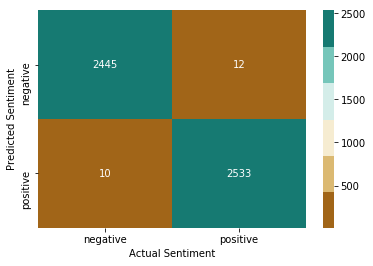

In [67]:
sns.heatmap(ct, annot = True, cmap=sns.color_palette("BrBG"),fmt="d" )

#### Explanation: 
This heatmap shows a confusion matrix. The confusion matrix depicts the number of false positives, true positives, false negatives, and true negatives that are being classified by the model. "The confusion matrix shows the ways in which your classification model is confused when it makes predictions"(https://www.geeksforgeeks.org/confusion-matrix-machine-learning/). 

Here, you can see that there are more true positives than false positives. As well, there is more true negatives than false negatives. Therefore, our model has predicted a majority of the labels accurately. 

## 6. Perfom Professor Teplovs orginial code that was in the notebook and get an output

In [68]:
#changes made the model return the accuracy score and the model 

In [69]:
# You should include the output from the following code in your notebook:
#with open("PATH_TO_YOUR_IMDB_MODEL", 'rb') as f:
with open(PATH, 'rb') as f:
    model = pickle.load(f)

yhat = model.predict([
    "This is the worst movie I have ever seen!",
    "The movie was great action packed and full of adventure!",
    "Wow!",
    "This was the best and the worst at the same time!"
])

print(model)
print(yhat)
#print(model.labels_.inverse_transform(yhat))

Pipeline(memory=None,
         steps=[('preprocessor',
                 NLTKPreprocessor(lower=True,
                                  punct={'!', '"', '#', '$', '%', '&', "'", '(',
                                         ')', '*', '+', ',', '-', '.', '/', ':',
                                         ';', '<', '=', '>', '?', '@', '[',
                                         '\\', ']', '^', '_', '`', '{', '|', ...},
                                  stopwords={'0', '1', '2', '3', '4', '5', '6',
                                             '7', '8', '9', 'a', 'about',
                                             'above', 'after', 'again',
                                             'against', 'ain', 'all', 'am',
                                             'an', 'and', 'any', 'are', 'aren',
                                             "...
                ('classifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early

In [70]:
print(show_most_informative_features(model))

3.5587      excellent    -5.9002            bad
3.2211          great    -4.1733          waste
2.9065        perfect    -4.0393         boring
2.4466            fun    -3.5487          awful
2.2438            job    -3.5158        nothing
2.1418      fantastic    -2.8812       terrible
2.1244       favorite    -2.7944           poor
2.1055      wonderful    -2.6576         minute
2.0794          enjoy    -2.5629           dull
2.0776     especially    -2.5172     ridiculous
2.0644           best    -2.3295    forgettable
2.0208           seat    -2.3073           fail
1.9387         subtle    -2.1062           weak
1.9115           love    -2.0984         script
1.8793          worth    -2.0859       horrible
1.8575      recommend    -2.0756      laughable
1.8538            yet    -2.0622          might
1.7871           hook    -2.0507           lack
1.7831      enjoyable    -2.0373         mildly
1.7691     unexpected    -2.0162        suppose


#### Explanation: 

Above shows a list of the most informative features for the model. In other words, the output allows the user to see the words that are most highly associated with each sentiment. 

These words are important in predicting the sentiment label for a review. The top 3 words that help predict positive sentiment are words excellent, great, and perfect. The top 3 words that help predict whether a review has negative sentiment are words bad, waste, and boring. 